# Advanced Lane Lines - HOG and color feature extraction

In this notebook the following points from the Project 5 Vehicle Detection are implemented:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing. 


---
## Step 0: Import required libraries

In [1]:
from skimage.feature import hog

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from IPython.display import HTML

import numpy as np
import pickle
import cv2
import glob
import time
import os

%matplotlib inline

## Step 1:  Explore vehicle and non-vehicle data set

In [2]:
def readImages(dir):

    images = []
    for dirPath, dirNames, fileNames in os.walk(dir):
        for dirName in dirNames:
            images.append(glob.glob(dir + '/' + dirName + '/' + '*.png'))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: mpimg.imread(img), flatten)) 

len(vehicleImages): 8792
len(nonVehicleImages): 8968


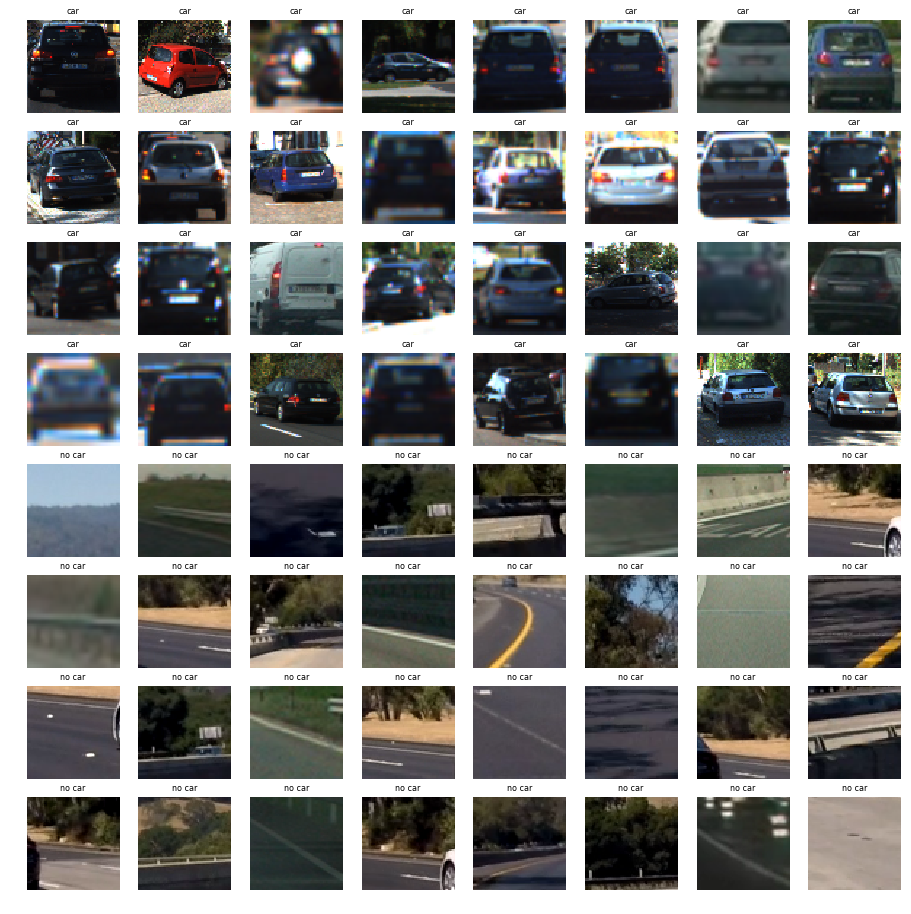

In [3]:
vehicleImages = readImages('./data/vehicles')
nonVehicleImages = readImages('./data/non-vehicles')

print("len(vehicleImages): {}".format(len(vehicleImages)))
print("len(nonVehicleImages): {}".format(len(nonVehicleImages)))

fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(32):
    image = vehicleImages[np.random.randint(0,len(vehicleImages))]
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=8)
    axs[i].imshow(image)
for i in np.arange(32,64):
    image = nonVehicleImages[np.random.randint(0,len(nonVehicleImages))]
    axs[i].axis('off')
    axs[i].set_title('no car', fontsize=8)
    axs[i].imshow(image) 

## Step 2: Define parameters in a dictionary for tuning

In [4]:
configParams = {
           
    # Flags for which features to use
    'use_hog_feat':True,
    'use_spatial_feat':True, 
    'use_hist_feat':True,     
    
    # Color feature params
    'color_cspace':'YCrCb',
    'color_spatial_size':(32, 32),
    'color_hist_bins':32,
    'color_hist_range':(0, 256),
    
    # HOG feature params
    'use_gray_img':False,
    'hog_channel':'ALL',
    'hog_cspace':'YCrCb',
    'hog_n_orientations': 9,
    'hog_pixels_per_cell': 8,
    'hog_cells_per_block': 2,
    
    # Heatmap
    'heat_threshold': 2,  
    'buffer_len_hotwindows': 5,  
} 

## Step 3: Udacity functions for extracting HOG and color features

In [5]:
def transform_colorspace(image, cspace):
    # apply color conversion if other than 'RGB'
    # cspace = dict_config_params['color_space']
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)  
        
    return feature_image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)        
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        hog_image = None
        
    return features, hog_image
        
def extract_hog_features(image, hog_feat=True, visualize=False):
    
    if hog_feat is not True:
        return [], None
    
    if configParams['use_gray_img'] is True:
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        feature_image = transform_colorspace(image, configParams['hog_cspace'])
    
    # Parameters
    hog_channel = configParams['hog_channel']
    n_orientations = configParams['hog_n_orientations']
    pixels_per_cell = configParams['hog_pixels_per_cell']
    cells_per_block = configParams['hog_cells_per_block']
    
    hog_features = []
    single_channel_img = len(feature_image.shape)==2
    
    if hog_feat == True:     
        if single_channel_img is True:
            hog_features, hog_image = get_hog_features(feature_image, 
                                                       n_orientations, 
                                                       pixels_per_cell, cells_per_block, 
                                                       vis=visualize, feature_vec=False)
        
        elif hog_channel == 'ALL':            
            for channel in range(feature_image.shape[2]):
                features, hog_image = get_hog_features(feature_image[:,:,channel], 
                                                       n_orientations, 
                                                       pixels_per_cell, cells_per_block, 
                                                       vis=visualize, feature_vec=False)
                hog_features.append(features)                
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                                       n_orientations, 
                                                       pixels_per_cell, cells_per_block, 
                                                       vis=visualize, feature_vec=False)
        
    return hog_features, hog_image

# Define a function to compute binned color features  
def bin_spatial(img):
        
    size = configParams['color_spatial_size']
    
    features = cv2.resize(img, size).ravel() 
    return features


# Define a function to compute color histogram features  
def color_hist(img):
    nbins = configParams['color_hist_bins']
    bins_range = configParams['color_hist_range']
    
    # Compute the histograms of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def extract_color_features(image, spatial_feat=True, hist_feat=True):

    color_features = []
    
    if spatial_feat is not True and hist_feat is not True:
        return color_features
    
    feature_image = transform_colorspace(image, configParams['color_cspace'])
    
    # Get spatial color features
    if spatial_feat is True:
        spatial_features = bin_spatial(feature_image)
        color_features.append(spatial_features)
    
    # Get color histogram features
    if hist_feat is True:
        hist_features = color_hist(feature_image)
        color_features.append(hist_features)
    
    # Concatenate spatial and histogram features
    color_features = np.concatenate(color_features)
        
    # Return list of feature vectors
    return color_features

## Step 4: Combine HOG and color extracting of features

In [6]:
def extractFeatures(image, verbose=True, hog_feat=True, spatial_feat=True, hist_feat=True):   

    features = []
    
    # --- Extract HOG features ---    
    hogFeatures, hogImage = extract_hog_features(image, hog_feat=hog_feat, visualize=verbose)    
    features.append(np.ravel(hogFeatures))    

    # --- Extract Color features ---
    colorFeatures = extract_color_features(image, spatial_feat=spatial_feat, hist_feat=hist_feat)    
    features.append(colorFeatures)
    
    if verbose is True:
        print()
        print("len(hogFeatures): {}".format(len(hogFeatures)))
        print("len(colorFeatures): {}".format(len(colorFeatures)))
        
        if hogImage is not None:
            # Plot 
            fig = plt.figure()
            plt.subplot(121)
            plt.imshow(image, cmap='gray')
            plt.title('Example Image')
            plt.subplot(122)
            plt.imshow(hogImage, cmap='gray')
            plt.title('HOG Visualization')
    
    return np.concatenate(features)

## Step 5: Apply feature extraction (HOG and color) to a random test image

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



len(hogFeatures): 3
len(colorFeatures): 3168

len(imgFeatures): 8460


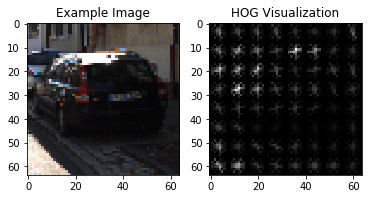


len(hogFeatures): 3
len(colorFeatures): 3168

len(imgFeatures): 8460


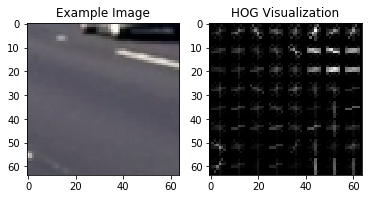

In [7]:
# Take a random image
image = vehicleImages[np.random.randint(0, len(vehicleImages))]
    
hog_feat = configParams['use_hog_feat']
spatial_feat = configParams['use_spatial_feat']
hist_feat = configParams['use_hist_feat']
        
imgFeatures = extractFeatures(image, verbose=True, hog_feat=hog_feat, spatial_feat=spatial_feat, hist_feat=hist_feat)
    
print()
print("len(imgFeatures): {}".format(len(imgFeatures)))
        
plt.show()

image = nonVehicleImages[np.random.randint(0, len(nonVehicleImages))]
    
hog_feat = configParams['use_hog_feat']
spatial_feat = configParams['use_spatial_feat']
hist_feat = configParams['use_hist_feat']
        
imgFeatures = extractFeatures(image, verbose=True, hog_feat=hog_feat, spatial_feat=spatial_feat, hist_feat=hist_feat)
    
print()
print("len(imgFeatures): {}".format(len(imgFeatures)))
        
plt.show()